# Data Exploration: Munich Bicycle Counting Stations

There are 6 bicycle counting stations in munich and all of them also record meteorological data.


## Load the data

In [2]:
import pandas as pd

# Read the counting data from the json file, set the datum as index, but also keep the datum column
counting_data_file = "../datasources/munich-bicycle-counting-stations/cleaned/bicycle-counting-station-daily.json"
df = pd.read_json(counting_data_file, lines=True)
df['datum'] = pd.to_datetime(df['datum'], unit='ms')
df['datum_index'] = df['datum']
df.set_index('datum_index', inplace=True)

# Data should be sorted in the file, but just to be sure
df.sort_values(by='datum', inplace=True)

# Calculate the average temperature
df['avg-temp'] = (df['min-temp'] + df['max-temp']) / 2

# Create a complete date range from min to max date in your data
complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Find missing dates
missing_dates = complete_date_range.difference(df.index)

assert len(missing_dates) == 0
print("There are no missing dates, continuing")

There are no missing dates, continuing


In [3]:
# We want to find the sum of all bikes that passed the counting stations on a given day
# so we group by the date and sum the values.
# The environmental values are the same for all stations, so we can just take the first value

aggregation_functions = {'datum': 'first',
                         'min-temp': 'first',
                         'max-temp': 'first',
                         'avg-temp': 'first',
                         'niederschlag': 'first',
                         'bewoelkung': 'first',
                         'sonnenstunden': 'first',
                         'gesamt': 'sum'}

aggregated_df = df.groupby(df['datum']).aggregate(aggregation_functions)
# Assuming 'datum' column is in datetime format
aggregated_df['monat'] = aggregated_df['datum'].dt.month
aggregated_df['woche'] = aggregated_df['datum'].dt.strftime('%U')
aggregated_df['vortag_gesamt'] = aggregated_df['gesamt'].shift(1)
aggregated_df['avg_last_week'] = aggregated_df['gesamt'].rolling(window='7D').mean()

# Drop rows with NaN values in the 'avg_last_week' column
aggregated_df.dropna(subset=['avg_last_week'], inplace=True)
aggregated_df.dropna(inplace=True)

aggregated_df.head(20)

,datum,min-temp,max-temp,avg-temp,niederschlag,bewoelkung,sonnenstunden,gesamt,monat,woche,vortag_gesamt,avg_last_week
datum,,,,,,,,,,,,
2008-06-02,2008-06-02,15.0,27.9,21.45,0.6,44,12.1,1117,6,22,667.0,892.000000
2008-06-03,2008-06-03,14.6,21.9,18.25,0.2,88,3.2,1279,6,22,1117.0,1021.000000
2008-06-04,2008-06-04,14.8,21.9,18.35,5.1,91,1.4,758,6,22,1279.0,955.250000
2008-06-05,2008-06-05,14.0,20.4,17.20,14.2,91,0.6,606,6,22,758.0,885.400000
2008-06-06,2008-06-06,13.6,19.9,16.75,10.0,81,1.7,963,6,22,606.0,898.333333
2008-06-07,2008-06-07,13.6,18.2,15.90,2.0,95,0.7,399,6,22,963.0,827.000000
2008-06-08,2008-06-08,12.6,22.0,17.30,3.9,83,5.4,557,6,23,399.0,811.285714
2008-06-09,2008-06-09,9.5,23.0,16.25,0.0,63,11.5,1244,6,23,557.0,829.428571
2008-06-10,2008-06-10,12.2,25.7,18.95,0.8,48,12.7,1350,6,23,1244.0,839.571429


In [4]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define features and target variables
features = ['monat', 'avg_last_week', 'vortag_gesamt', 'min-temp', 'max-temp', 'avg-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden']
#features = ['min-temp', 'max-temp', 'avg-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden']
target = 'gesamt'

# Splitting the data into training and testing sets based on the date
train_data = aggregated_df[aggregated_df['datum'] < '2023-01-01']
test_data = aggregated_df[aggregated_df['datum'] >= '2023-01-01']

# Splitting the features and target for training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


In [15]:
# Creating and fitting the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 9695052.553817267


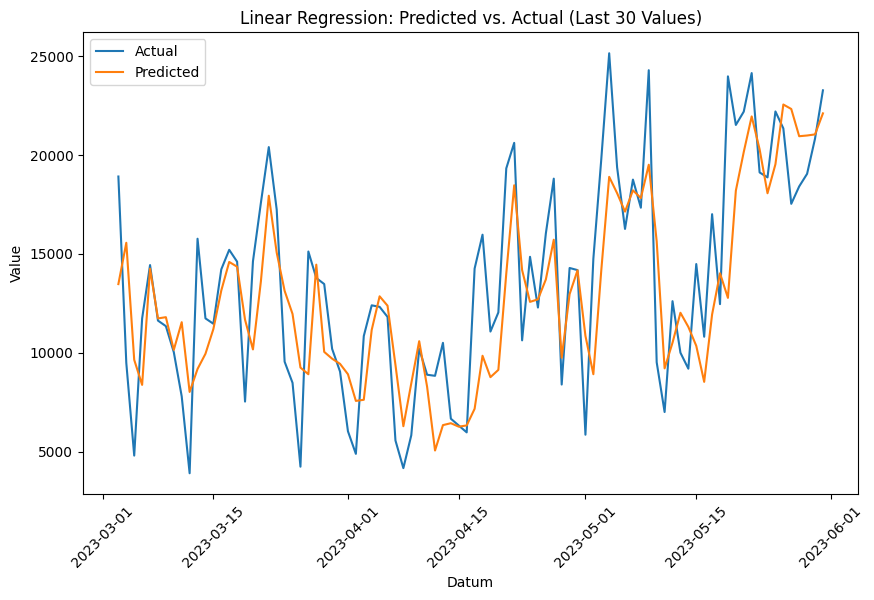

In [16]:
# Plotting predicted vs. actual values with 'datum' as the x-axis
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[-90:], y_test[-90:], label='Actual')
plt.plot(y_test.index[-90:], y_pred[-90:], label='Predicted')
plt.xlabel('Datum')
plt.ylabel('Value')
plt.title('Linear Regression: Predicted vs. Actual (Last 30 Values)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [13]:
from sklearn.ensemble import RandomForestRegressor

# Creating and fitting the Random Forest model
model = RandomForestRegressor(n_estimators=200, n_jobs=6)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 10140153.063588906


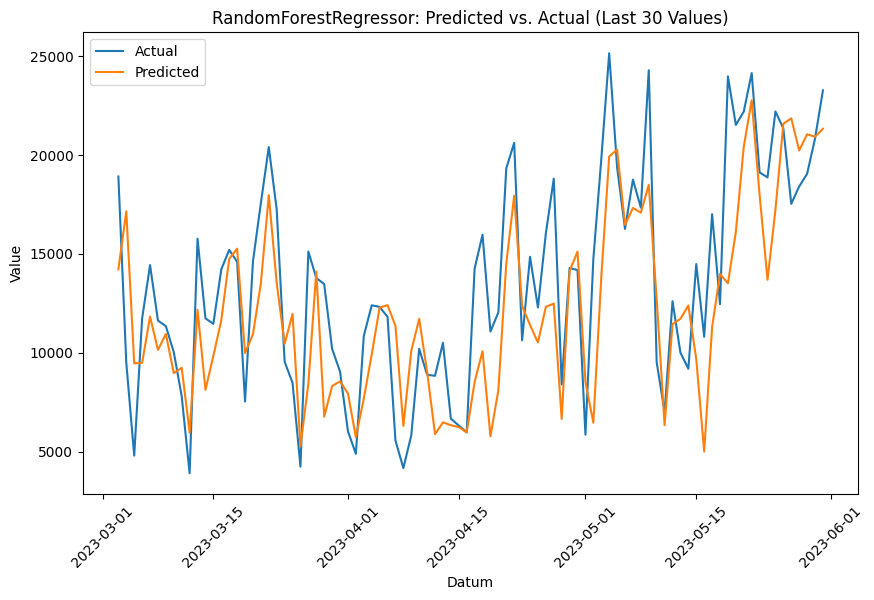

In [14]:
# Plotting predicted vs. actual values with 'datum' as the x-axis
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[-90:], y_test[-90:], label='Actual')
plt.plot(y_test.index[-90:], y_pred[-90:], label='Predicted')
plt.xlabel('Datum')
plt.ylabel('Value')
plt.title('RandomForestRegressor: Predicted vs. Actual (Last 30 Values)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y_train,
                exog=X_train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))

# Fit the model
model_fit = model.fit(disp=False)



/home/jonas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jonas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jonas/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyError: 0

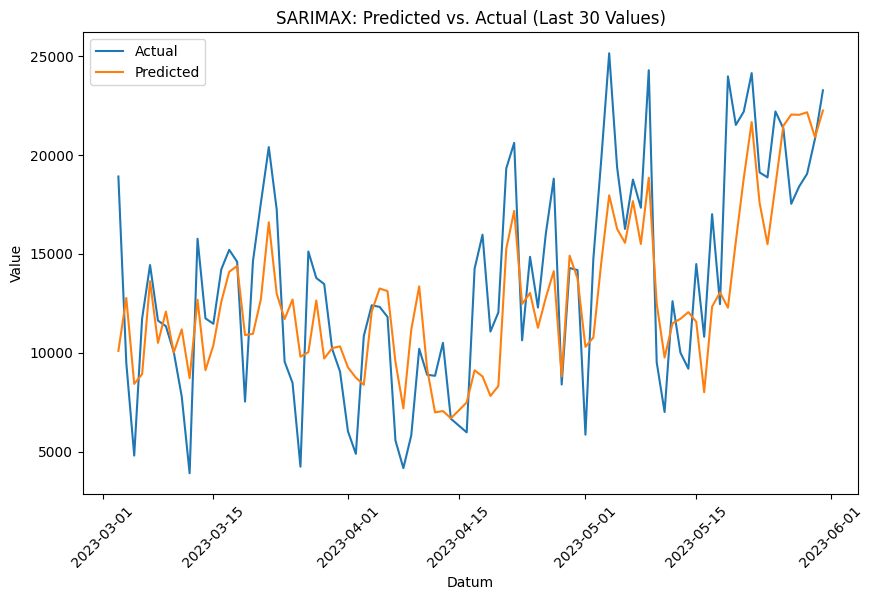

In [12]:
# Predict on the test set
start = X_test.index[0]
end = X_test.index[-1]

y_pred = model_fit.predict(start=start, end=end, exog=X_test)

# Plotting predicted vs. actual values with 'datum' as the x-axis
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[-90:], y_test[-90:], label='Actual')
plt.plot(y_test.index[-90:], y_pred[-90:], label='Predicted')
plt.xlabel('Datum')
plt.ylabel('Value')
plt.title('SARIMAX: Predicted vs. Actual (Last 30 Values)')
plt.xticks(rotation=45)
plt.legend()
plt.show()